In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Network import Place_net, Grid_net, Coupled_Net
import brainpy as bp
import brainpy.math as bm
from matplotlib.animation import FuncAnimation
from scipy.signal import find_peaks

ModuleNotFoundError: No module named 'Network'

## Set network parameters

In [ ]:
# 默认参数
# grid spacing
lambda_1 = 3
lambda_2 = 4
lambda_3 = 5
Lambda = np.array([lambda_1, lambda_2, lambda_3])
L = lambda_1 * lambda_2 * lambda_3
# cell number
num_p = int(1280)*2
rho_p = num_p/L
rho_g = rho_p
num_g = int(rho_g*2*np.pi) # 为了让两个网络的rho相等
M = len(Lambda)
# feature space
x = np.linspace(0, L, num_p, endpoint=False)
theta = np.linspace(0, 2 * np.pi, num_g, endpoint=False)
# connection range
a_p = 0.3
a_g = a_p/Lambda*2*np.pi
# connection strength
J_p = 20
J_g = J_p
J_pg = J_p/50
# divisive normalization
k_p = 20.
k_g = Lambda/2/np.pi * k_p
# time constants
tau_p = 1.
tau_g = 2*np.pi * tau_p/Lambda

## Generate input signal

In [ ]:
# 圆周距离函数
def circ_dis(phi_1, phi_2):
    dis = phi_1 - phi_2
    dis = bm.where(dis>bm.pi, dis-2*bm.pi, dis)
    dis = bm.where(dis<-bm.pi, dis+2*bm.pi, dis)
    return dis
def generate_model(sigma_phi_generate, sigma_g_generate, sigma_p_generate, alpha_p, alpha_g):

    z_truth = 30
    phi_truth = np.mod(z_truth / Lambda, 1) * 2 * np.pi 
    psi = phi_truth + sigma_phi_generate * np.random.randn(M)
    # psi = phi_truth 
    Ig = np.zeros((M, num_g))
    for i in range(M):
        dis_theta = circ_dis(theta, psi[i])
        Ig[i, :] = alpha_g*(np.exp(-dis_theta**2 / (4 * a_g[i] ** 2)) + sigma_g_generate * np.random.randn(num_g))
    x = np.linspace(0,L,num_p,endpoint=False)
    dis_x = x-z_truth
    Ip = alpha_p*(np.exp(-dis_x**2 / (4 * a_p**2)) + sigma_p_generate * np.random.randn(num_p))
    return Ip, Ig


## Calculate Energy function

In [ ]:

# Calculate A, R based on theoretical formula
def Get_energy(alpha_p, alpha_g, Ig, Ip, candidate_num):
    Ag = 1./(4*np.sqrt(np.pi)*a_g*rho_g*k_g)*(rho_g*J_g+np.sqrt((rho_g*J_g)**2-8*np.sqrt(2*np.pi)*a_g*rho_g*k_g))
    Ap = 1./(4*np.sqrt(np.pi)*a_p*rho_p*k_p)*(rho_p*J_p+np.sqrt((rho_p*J_p)**2-8*np.sqrt(2*np.pi)*a_p*rho_p*k_p))
    Rg = Ag**2/(1+k_g*rho_g*a_g*np.sqrt(2*np.pi)*Ag**2)


    sigma_g = np.sqrt(np.sqrt(np.pi)*Ag**3*rho_g*tau_g/(a_g*alpha_g + 1e-8)) 
    sigma_phi = 1/((Lambda/2/np.pi) * np.sqrt(J_pg*rho_g*Rg/(4*Ap*tau_p))) 
    sigma_p = np.sqrt(np.sqrt(np.pi)*Ap**3*rho_p*tau_p/(a_p*alpha_p + 1e-8)) 

    print('sigma_g:', sigma_g)
    print('sigma_phi:', sigma_phi)

    z_candidate = np.linspace(0, L , candidate_num)
    phi_candidate = np.mod(z_candidate.reshape(candidate_num,1) / Lambda.reshape(1,M), 1) * 2 * np.pi
    Energy = np.zeros(candidate_num,)
    # 后验概率计算函数

    def circ_dis_L(x1, x2, L):
        dis = x1 - x2
        dis = bm.where(dis>L/2, dis-L, dis)
        dis = bm.where(dis<-L/2, dis+L, dis)
        return dis

    def calculate_posterior(z, phi, Ig, Ip):
        x = np.linspace(0,L,num_p,endpoint=False)
        theta = np.linspace(0,2*np.pi,num_g,endpoint=False)
        psi_z = np.mod(z / Lambda, 1) * 2 * np.pi
        log_prior = 0
        log_likelihood_grid = 0
        for i in range(M):
            dis_1 = circ_dis(theta, phi[i])
            fg = np.exp(-dis_1**2 / (4 * a_g[i]**2))
            log_likelihood_grid -= np.sum((Ig[i, :] - fg)**2) / sigma_g[i]**2
            dis_2 = circ_dis(phi[i], psi_z[i])
            log_prior -= 1 / (sigma_phi[i]**2) * np.exp(-dis_2**2/8/a_g[i]**2) * dis_2**2
        dis_x = circ_dis_L(x, z, L)
        fp = np.exp(-dis_x**2 / (4 * a_p ** 2))
        log_likelihood_place = -np.sum((Ip - fp)**2) / sigma_p**2
        log_posterior = log_likelihood_grid + log_prior + log_likelihood_place
        # log_posterior = log_likelihood_place

        return log_posterior

    # 计算能量
    for i in range(candidate_num):
        Energy[i] = -calculate_posterior(z_candidate[i], phi_candidate[i], Ig, Ip)
    return Energy




sigma_g: [14.43878731 14.43878727 14.43878723]
sigma_phi: [24.90669557 18.68002168 14.94401734]
global_minimum: 54.114114114114116


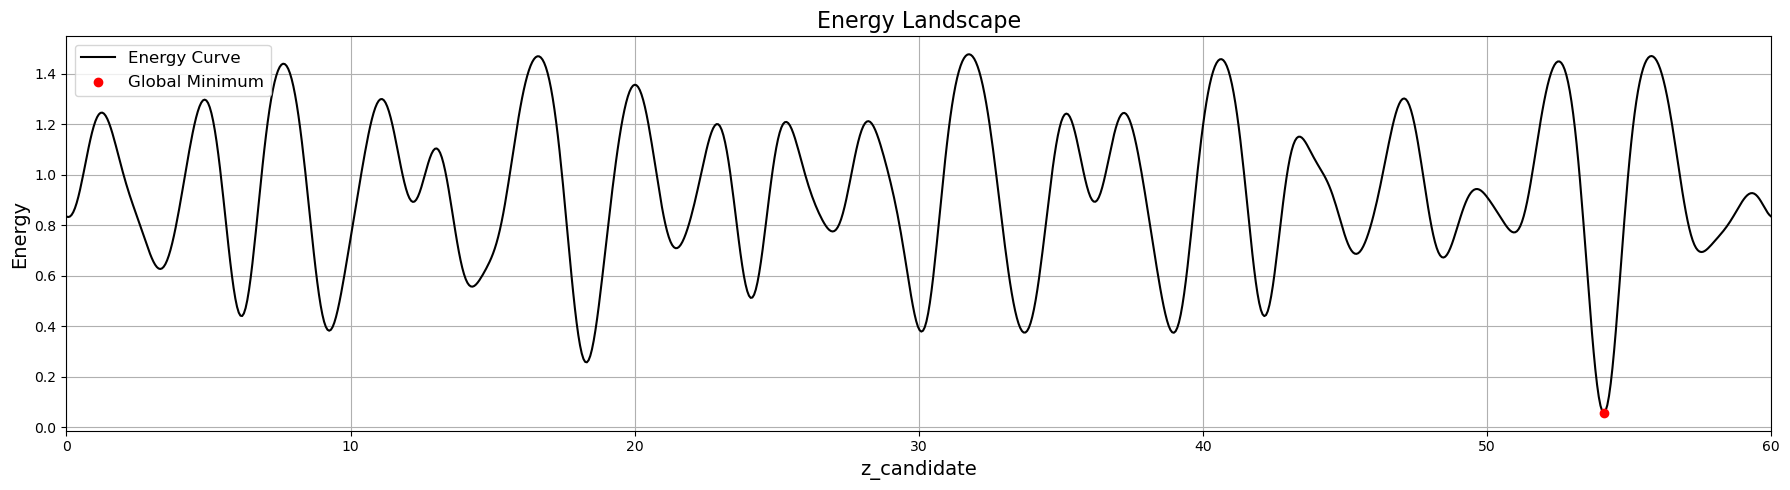

In [ ]:
# 生成I_p, I_g
sigma_phi_generate = 0.5
sigma_g_generate = 0.1
sigma_p_generate = 0.1
# input_strength
alpha_p = 0.0
alpha_g = 1.
Ip, Ig = generate_model(sigma_phi_generate, sigma_g_generate, sigma_p_generate, alpha_p, alpha_g)
Energy = Get_energy(alpha_p, alpha_g, Ig, Ip, candidate_num=1000)
candidate_num = 1000
z_candidate = np.linspace(0, L , candidate_num)
# 找到局部最小值
peaks, _ = find_peaks(-Energy)
local_minima = peaks

# 找到全局最小值
global_minimum = np.argmin(Energy)
# print('all local minima:', z_candidate[local_minima])
print('global_minimum:', z_candidate[global_minimum])
# 画图
# Energy = Energy-np.min(Energy)
fig = plt.figure(figsize=(18, 5))
plt.plot(z_candidate, np.exp(Energy), label='Energy Curve', color='black', linewidth=1.5)
# plt.scatter(z_candidate[local_minima], Energy[local_minima], color='blue', label='Local Minima', zorder=5)
plt.scatter(z_candidate[global_minimum], Energy[global_minimum], color='red', label='Global Minimum', zorder=5)
plt.xlabel('z_candidate', fontsize=14)
plt.ylabel('Energy', fontsize=14)
plt.title('Energy Landscape', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.xlim(0, L)
# plt.ylim(0, 1)
plt.tight_layout()

# plt.show()